In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from macrohet import visualise, dataio, tile
from tqdm.auto import tqdm
import os
import btrack
import json
import napari
import matplotlib as mpl
import matplotlib.patches as patches

scale_factor = 6048/1200

# Function to calculate gradient for a window
def calculate_gradient(window):
    y = window
    x = np.arange(len(window))
    slope, _ = np.polyfit(x, y, 1)
    return slope

### Set style for plotting

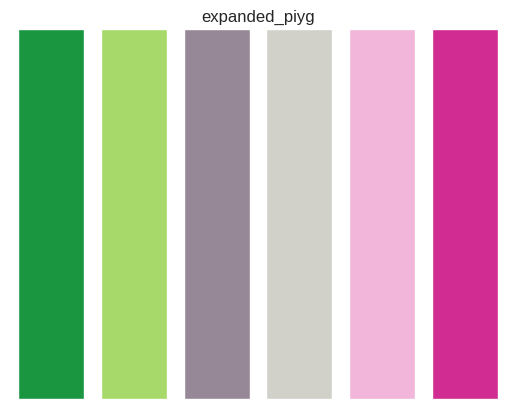

['#1a9641', '#a6d96a', '#978897', '#d1d1ca', '#f1b6da', '#d02c91']


In [2]:
sns.set(style = 'white')

# Set the default font to Helvetica
mpl.rcParams['font.family'] = 'Liberation Sans'

# Get the color palette of the PiYG color map
expanded_piyg = visualise.color_palette('expanded_piyg').colors

sns.set_palette(expanded_piyg)

# Display the colors in the PiYG color map
visualise.show_colors('expanded_piyg')
print(expanded_piyg)

### Load sc df

In [3]:
df = pd.read_pickle('/mnt/DATA/macrohet/results/preliminary_sc_measures/sc_dfs/sc_df_GT_70_interp.pkl')
df['dMtb'] = df['delta Mtb max fold-change normalised max area']
df['Mtb'] = df['Intracellular thresholded Mtb content smooth']
# Assuming your DataFrame is named 'df'
df['Strain/Compound'] = df['Compound']  # Create a new column and copy values from 'Compound'
# Replace values in 'NewColumn' where 'Strain' is 'RD1' with 'RD1'
df.loc[df['Strain'] == 'RD1', 'Strain/Compound'] = 'RD1'
df

,Time (hours),x,y,x scaled,y scaled,Infection status,Initial infection status,Final infection status,Area,Intracellular mean Mtb content,...,Strain,Compound,Concentration,Technical replicate,Cell ID,Acquisition ID,Unique ID,dMtb,Mtb,Strain/Compound
0,0,457.172943,8.791715,2304.151633,44.310242,1.0,1.0,0.0,20542.0,343.157196,...,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.912650,RD1
1,1,459.138947,6.718642,2314.060291,33.861954,0.0,1.0,0.0,16683.0,344.687042,...,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.912650,RD1
2,2,460.555237,10.785886,2321.198394,54.360864,0.0,1.0,0.0,18935.0,343.875061,...,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.912650,RD1
3,3,455.878815,11.143067,2297.629226,56.161059,1.0,1.0,0.0,19937.0,345.565796,...,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.912650,RD1
4,4,462.634186,14.050420,2331.676296,70.814116,1.0,1.0,0.0,21793.0,350.585083,...,RD1,CTRL,EC0,1,426,"(3, 4)",426.3.4,0.000586,0.912650,RD1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296992,70,628.562500,1099.782104,3167.955000,5542.901807,1.0,0.0,1.0,101991.0,377.731873,...,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9,0.000030,5.031497,BDQ
296993,71,628.463684,1102.144409,3167.456968,5554.807822,1.0,0.0,1.0,100978.0,377.812103,...,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9,0.000030,5.274554,BDQ
296994,72,628.672058,1101.594727,3168.507173,5552.037422,1.0,0.0,1.0,108397.0,376.812805,...,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9,0.000030,5.220153,BDQ
296995,73,630.372803,1102.817749,3177.078926,5558.201455,1.0,0.0,1.0,107079.0,377.437073,...,WT,BDQ,EC99,2,935,"(6, 9)",935.6.9,0.000030,5.002094,BDQ


### Calculate the maximum gradient for each cell

In [4]:
# df['Max. dMtb gradient'] = np.nan  # Initialize with NaN instead of None
for unique_ID in tqdm(df['Unique ID'].unique()):
    sc_df = df[df['Unique ID'] == unique_ID]

    max_gradient = sc_df['Mtb'].rolling(window=15).apply(calculate_gradient, raw=True).max()
    df.loc[df['Unique ID'] == unique_ID, 'Max. dMtb gradient'] = max_gradient
    if max_gradient > 120:
        print(unique_ID)

  0%|          | 0/3988 [00:00<?, ?it/s]

280.3.5
85.4.5


### Isolate the top ten fastest growers

In [5]:
N = 100
top_N_tracks = df.groupby('Unique ID')['Max. dMtb gradient'].max().sort_values(ascending=False).head(N)

## Plot an outlier

In [6]:
track_id = '264.4.6'

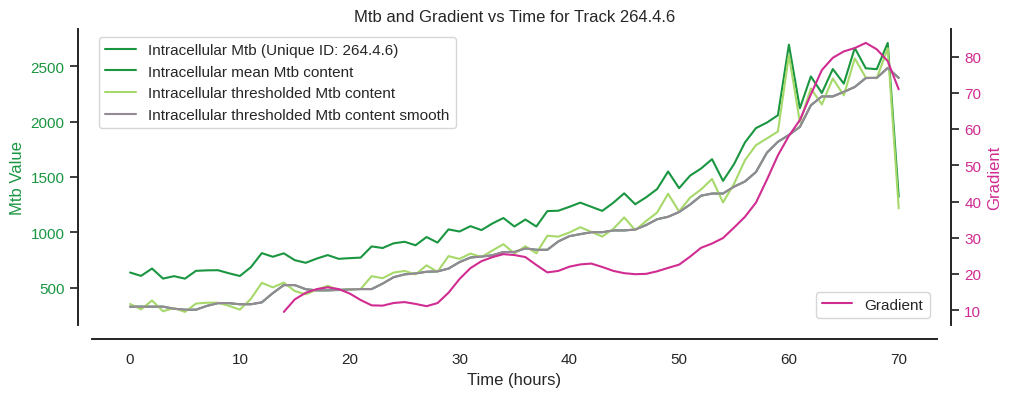

In [8]:
track_data = df[df['Unique ID'] == track_id]

# Convert to NumPy array for compatibility
time_values = track_data['Time (hours)'].values
mtb_values = track_data['Mtb'].values
gradient_values = track_data['Mtb'].rolling(window=15).apply(calculate_gradient, raw=True).values

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 4))

# Plot Mtb values
color = expanded_piyg[0]
ax1.set_xlabel('Time (hours)')
ax1.set_ylabel('Mtb Value', color=color)
ax1.plot(time_values, mtb_values, label=f'Intracellular Mtb (Unique ID: {track_id})', color=color)
ax1.tick_params(axis='y', labelcolor=color)
for i in ['Intracellular mean Mtb content',
       'Intracellular thresholded Mtb content',
       'Intracellular thresholded Mtb content smooth']:
    ax1.plot(time_values, track_data[i].values, label = i)

# Create a twin axis for the gradient
ax2 = ax1.twinx() 
color = expanded_piyg[-1]
ax2.set_ylabel('Gradient', color=color)  
ax2.plot(time_values, gradient_values, label='Gradient', color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax1.legend(loc='upper left')
ax2.legend(loc='lower right')

plt.title(f'Mtb and Gradient vs Time for Track {track_id}')
fig.tight_layout()
sns.despine(offset = 10, right = False)
plt.show()

### What does this cell look like when the area of Mtb is plotted?

In [10]:
track_data.keys()

Index(['Time (hours)', 'x', 'y', 'x scaled', 'y scaled', 'Infection status',
       'Initial infection status', 'Final infection status', 'Area',
       'Intracellular mean Mtb content',
       'Intracellular thresholded Mtb content',
       'Intracellular thresholded Mtb content smooth',
       'Macroph. GFP expression', 'delta Mtb raw', 'delta Mtb max raw',
       'delta Mtb max smooth', 'delta Mtb max fold-change',
       'delta Mtb max fold-change normalised mean area',
       'delta Mtb max fold-change normalised max area', 'delta Mtb/dt',
       'Eccentricity', 'MSD', 'Strain', 'Compound', 'Concentration',
       'Technical replicate', 'Cell ID', 'Acquisition ID', 'Unique ID', 'dMtb',
       'Mtb', 'Strain/Compound', 'Max. dMtb gradient'],
      dtype='object')

In [9]:
base_dir = '/mnt/DATA/macrohet/macrohet_images/PS0000/'
metadata_path = os.path.join(base_dir, 'Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
Row Column                                              
3   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
4   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA            60            EC50
    7          WT      RIF           0.1            EC50
    8          WT      INH          0.04            EC50
    9          WT      BDQ          0.02            EC50
5   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99
6   4         RD1     CTRL             0             EC0
    5          WT     CTRL             0             EC0
    6          WT      PZA           400            EC99
    7          WT      RIF             2            EC99
    8          WT      INH             2            EC99
    9          WT      BDQ           2.5            EC99

In [10]:
metadata_fn = os.path.join(base_dir, 'Images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


In [89]:
tracks_dict = dict()
segmentation_dict = dict()

### iterate over all experimental conditions
for (row, column), info in tqdm(assay_layout.iterrows(), 
                                desc = 'Progress through positions',
                                total = len(assay_layout)):

    ### load tracks
    with btrack.io.HDF5FileHandler(f'/mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/{row,column}.h5', 
                                       'r', 
                                       obj_type='obj_type_1'
                                       ) as reader:
        tracks = reader.tracks
        seg = reader.segmentation

            
    ### append tracks to dictionary
    tracks_dict[(row, column)] = tracks
    segmentation_dict[(row, column)] = seg

Progress through positions:   0%|          | 0/24 [00:00<?, ?it/s]

[INFO][2023/11/23 05:07:53 pm] Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5...
[INFO][2023/11/23 05:07:53 pm] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2023/11/23 05:07:53 pm] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2023/11/23 05:07:53 pm] Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (39878, 5) (39878 filtered: None)
[INFO][2023/11/23 05:08:03 pm] Loading segmentation (75, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (75, 6048, 6048)
[INFO][2023/11/23 05:08:03 pm] Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/DATA/macrohet/labels/PS0000/macrohet_seg_model/(3, 4).h5
[INFO][2023/11/23 05:08:03 pm] Opening HDF file: /mnt/DATA/macrohet/labels/P

In [ ]:
# Initialize an empty list to store Mtb area values
mtb_areas = []

for i, main_df_row in tqdm(df.iterrows(), total=df.shape[0]):
    track_id = main_df_row['Unique ID']
    # measuring the area of Mtb from the images... 
    track_data = df[df['Unique ID'] == track_id]
    
    # get acq ID and ID from track id'
    acq_ID = track_data['Acquisition ID'].iloc[0]
    cell_ID = track_data['Cell ID'].iloc[0]
    row, column = acq_ID
    image_dir = os.path.join(base_dir, 'Images')
    
    masks = segmentation_dict[acq_ID]
    # obtain mask information 
    for df_row in tqdm(track_data.iterrows(), total=len(track_data),
                        desc=f'Extracting measurements over each frame: {acq_ID, cell_ID}'):
            # get coords
            t, y, x = df_row[1]['Time (hours)'], int(df_row[1]['y']), int(df_row[1]['x'])
            y, x = int(y*scale_factor), int(x*scale_factor)
            # select proper frame
            frame = masks[t, ...]
            # check to see if mask exists
            if frame[y, x]:
                # select cell of interest
                mask = frame == frame[y, x]
                images = tile.compile_mosaic(image_dir, 
                                     metadata, 
                                     row, column, 
                                     set_plane='max_proj',
                                     set_channel=2,
                                     set_time = t,
        #                             input_transforms = [input_transforms]
                                    )[0,0].compute().compute()
                masked_image = images*mask 
                thresholded_masked_image = masked_image >=480
                mtb_area = np.sum(thresholded_masked_image)
                mtb_areas.append(mtb_area)
            else:
                mtb_areas.append(0)  # Append 0 if no mask exists
# Add the mtb_areas list as a new column to the DataFrame
df['Mtb Area'] = mtb_areas

  0%|          | 0/296997 [00:00<?, ?it/s]

Extracting measurements over each frame: ((3, 4), 426):   0%|          | 0/74 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 0) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 1) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 2) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 3) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 4) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 6) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 7) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 8) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 9) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 10) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 11) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 12) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 13) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 14) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 15) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 16) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 17) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 18) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 19) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 20) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 21) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 22) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 23) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 24) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 25) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 26) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 27) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 28) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 29) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 30) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 31) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 32) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 33) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 34) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:root:Entering function: compile_mosaic
 Parameters: row, col, plane, channel, time (3, 4, 'max_proj', 2, 35) 


Stitching images together:   0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
# Specify the file path and name for the output CSV file
output_file = 'area_df.csv'

# Save the DataFrame to a CSV file
df.to_csv(output_file, index=False)  # Set index=False to exclude row indices from the CSV file